In [1]:
import numpy             as np
import xarray            as xr
import pandas            as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

In [19]:
region_dict = {'cortex' :   ['VISp', 'VISl', 'VISrl', 'VISam', 'VISpm', 'VIS', 'VISal','VISmma','VISmmp','VISli'],
               'thalamus' : ['LGd','LD', 'LP', 'VPM', 'TH', 'MGm','MGv','MGd','PO','LGv','VL',
               'VPL','POL','Eth','PoT','PP','PIL','IntG','IGL','SGN','VPL','PF','RT'],
               'hippocampus' : ['CA1', 'CA2','CA3', 'DG', 'SUB', 'POST','PRE','ProS','HPF'],
               'midbrain':     ['MB','SCig','SCiw','SCsg','SCzo','PPT','APN','NOT','MRN','OP','LT','RPF','CP']}

color_dict = {'cortex' :      '#08858C',
              'thalamus' :    '#FC6B6F',
              'hippocampus' : '#7ED04B',
              'midbrain' :    '#FC9DFE'}

### Reading the data stored localy

In [2]:
nwb_path = '../data/ecephys_cache_dir/session_721123822/session_721123822.nwb'

session = EcephysSession.from_nwb_path(nwb_path, api_kwargs={
        "amplitude_cutoff_maximum": np.inf,
        "presence_ratio_minimum": -np.inf,
        "isi_violations_maximum": np.inf
    })

In [3]:
session.units.head()

,amplitude_cutoff,firing_rate,presence_ratio,snr,waveform_velocity_below,isolation_distance,silhouette_score,waveform_velocity_above,nn_miss_rate,waveform_PT_ratio,...,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_has_lfp_data,probe_lfp_sampling_rate,location,probe_description,probe_sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
950907205,0.012123,14.739577,0.99,2.838052,NaN,129.172458,0.193312,-0.892797,0.004831,1.054721,...,40,27,760213137,3,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907203,0.376577,2.533384,0.99,2.830406,NaN,63.408400,NaN,0.073582,0.000781,0.545221,...,40,59,760213137,2,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907524,0.002313,1.448536,0.99,4.285082,0.686767,50.450187,0.143138,0.068677,0.001834,0.558508,...,60,11,760213137,5,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907209,0.084063,0.040263,0.96,3.343694,0.000000,19.926951,NaN,0.156975,0.000467,0.637890,...,60,11,760213137,5,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907518,0.075400,0.062280,0.87,2.263385,NaN,35.003391,0.173800,0.206030,0.000000,0.434353,...,60,43,760213137,4,313.0,True,1249.998783,See electrode locations,probeA,29999.970785


In [4]:
len( session.spike_times.keys() )

/home/vinicius/.local/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


1191

(4000, 5000)

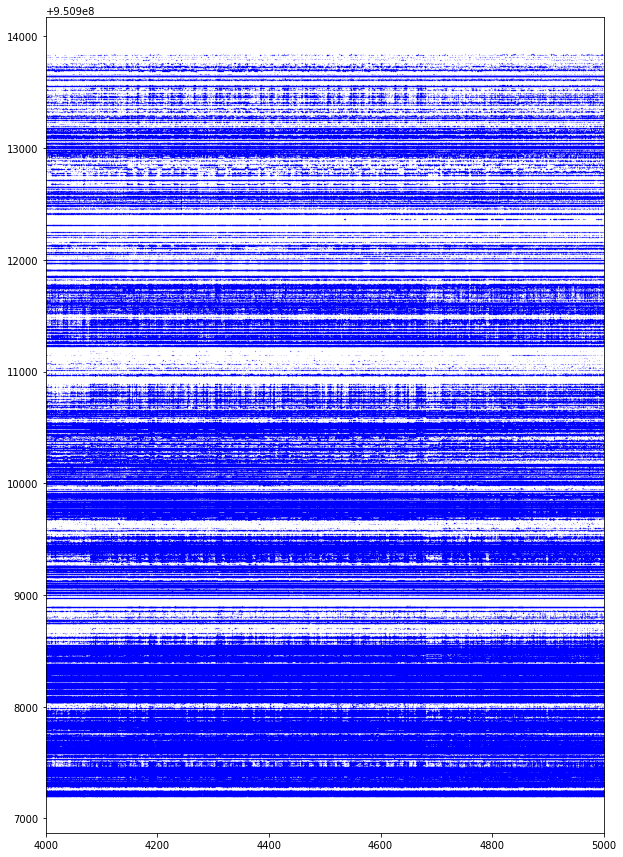

In [18]:
plt.figure(figsize=(10,15))
count = 0
for i in session.spike_times.keys():
    plt.plot(session.spike_times[i], [i]*len(session.spike_times[i]), 'b.', ms=.1)
    count += 1
#plt.ylim([0,len(session.spike_times.keys())])
plt.xlim([4000,5000])

In [27]:
units = session.units

In [28]:
region = 'cortex'

(4000, 5000)

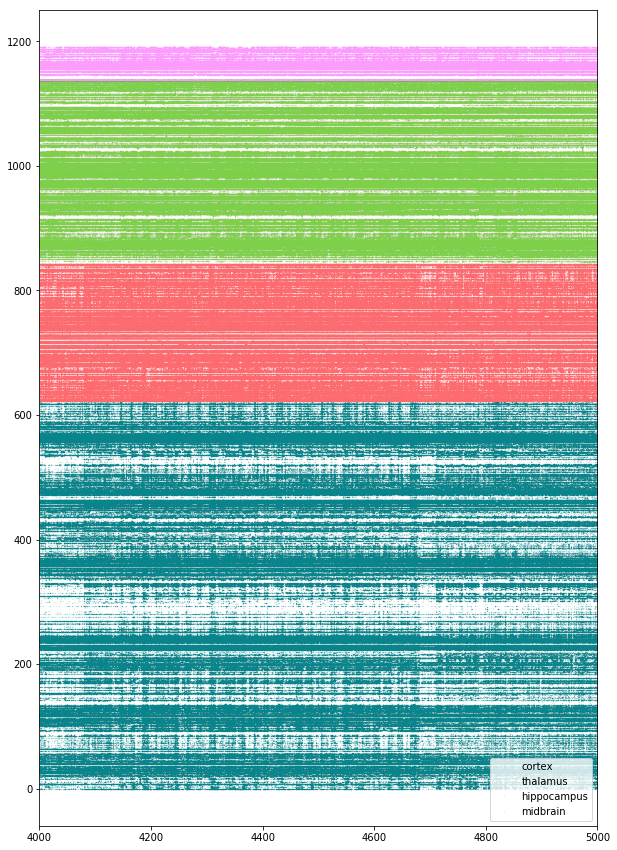

In [44]:
plt.figure(figsize=(10,15))
count = 0
for idx, region in enumerate(region_dict.keys()):
    ids = units[units.ecephys_structure_acronym.isin(region_dict[region])].index.values
    for i in ids:
        plt.plot(session.spike_times[i], [count]*len(session.spike_times[i]), '.', ms=.1, color = color_dict[region])
        count += 1
plt.legend(['cortex','thalamus','hippocampus','midbrain'])
plt.xlim([4000,5000])

In [42]:
for idx, region in enumerate(region_dict.keys()):
    print(region)

cortex
thalamus
hippocampus
midbrain
